In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline
from matplotlib import colors
import os
import io

In [595]:
# source = Image.open('input/rainbow.png')
source = Image.open('input/frog.png')
# source = Image.open('input/moscow.jpg')
secret = Image.open('input/field.jpg')

In [596]:
source_ratio = source.size[0] / source.size[1]
secret_ratio = secret.size[0] / secret.size[1]

if secret_ratio > source_ratio:
    secret = secret.resize((int(source.size[1] * secret_ratio),
                           source.size[1]))
    crop_x = round(secret.size[0] / 2 - source.size[0] / 2)
    secret = secret.crop((crop_x, 
                          0, 
                          crop_x + source.size[0], 
                          secret.size[1]))
else:
    secret = secret.resize((source.size[0], 
                            int(source.size[0] / secret_ratio)))
    crop_y = round(secret.size[1] / 2 - source.size[1] / 2)
    secret = secret.crop((0,
                          crop_y, 
                          secret.size[0], 
                          crop_y + source.size[1]))

# Старое решение

In [459]:
%%time

# gs = [0.2126, 0.7152, 0.0722]
gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.2
# t = secret_np.reshape((h, w, 1, 3)) @ gs.T

colors = source_np.reshape((h, w, 1, 3))
bcs = -gs * (colors @ gs.T - t) / (gs @ gs.T)

ks = np.zeros((h, w, 6, 3))
ks[...] = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

_tmp = np.reshape([0, 1] * 3, (3, 2))
alphas = _tmp - np.moveaxis(colors, -1, -2)
alphas = alphas.reshape((h, w, 6, 1))

matrix = np.zeros((3, 3))
matrix[0, 0] = gs[0, 1] ** 2 + gs[0, 2] ** 2
matrix[1, 1] = gs[0, 0] ** 2 + gs[0, 2] ** 2
matrix[2, 2] = gs[0, 0] ** 2 + gs[0, 1] ** 2
matrix[0, 1] = matrix[1, 0] = -gs[0, 0] * gs[0, 1]
matrix[0, 2] = matrix[2, 0] = -gs[0, 0] * gs[0, 2]
matrix[1, 2] = matrix[2, 1] = -gs[0, 1] * gs[0, 2]

ms = ks @ matrix

ks = ks.reshape((h, w, 6, 1, 3))
ms = ms.reshape((h, w, 6, 3, 1))
bcs = bcs.reshape((h, w, 1, 3, 1))
alphas = alphas.reshape((h, w, 6, 1, 1))

bbcs = ms * (alphas - ks @ bcs) / (ks @ ms) + bcs
bbcs = bbcs.reshape((h, w, 6, 3))

# print(bbcs[i, j]); print()

_c = np.round((colors.repeat(6, axis=2) + bbcs) * 255)
bbcs = np.where((_c < 0) | (_c > 255), 2, bbcs)

# print(bbcs[i, j]); print()

# bbcs = np.nan_to_num(bbcs, nan=2)

# _ds = np.sum((bbcs - bcs.reshape((h, w, 1, 3))) ** 2, axis=-1)
_ds = np.sum(bbcs ** 2, axis=-1)
_min_ds = np.min(_ds, axis=-1)[..., None]
bbcs = (_min_ds == _ds)[..., None] * bbcs
bbcs = bbcs.sum(axis=-2)

# print(bbcs[i, j]); print()

colors = colors.reshape((h, w, 3))
bcs = bcs.reshape((h, w, 3))

nc1 = np.round((colors + bcs) * 255)
nc2 = np.round((colors + bbcs) * 255)

# print(np.min(nc1), np.max(nc1))
# print(np.min(nc2), np.max(nc2))

# print(nc1[i, j]); print()


nc = np.full_like(colors, t * 255)
_nc1_cond = np.any(nc1 < 0, axis=-1) | np.any(nc1 > 255, axis=-1)
_nc2_cond = np.any(nc2 < 0, axis=-1) | np.any(nc2 > 255, axis=-1)
nc[~_nc1_cond] = nc1[~_nc1_cond]
nc[~_nc2_cond] = nc2[~_nc2_cond]

# _l_lim = np.any(nc1 < 0, axis=-1)
# _r_lim = np.any(nc1 > 255, axis=-1)
# _condition = (_l_lim | _r_lim)[..., None].repeat(3, -1)
# nc = np.where(_condition, nc2, nc1)#.astype('uint8')

# Image.fromarray((np.clip(color + bc, 0, 1) * 255).reshape((h, w, 3)).astype('uint8')).convert('L')

CPU times: user 2.4 s, sys: 978 ms, total: 3.37 s
Wall time: 5.07 s


Поиск пикселей, сильно отклонившихся от t:

In [314]:
# for i in range(h):
#     for j in range(w):
#         val = round((nc[i, j] / 255) @ gs.flatten(), 2)
#         if val != t:
#             print(f'[{i:>3}, {j:>3}]; val = {val}')

[165, 390]; val = 0.59
[166, 363]; val = 0.54
[166, 364]; val = 0.54
[166, 365]; val = 0.54
[166, 366]; val = 0.55
[166, 367]; val = 0.55
[166, 762]; val = 0.56
[167, 377]; val = 0.55
[167, 762]; val = 0.57
[168, 377]; val = 0.53
[168, 762]; val = 0.54
[169, 378]; val = 0.53
[169, 379]; val = 0.52
[169, 381]; val = 0.54
[169, 762]; val = 0.53
[170, 381]; val = 0.57
[170, 382]; val = 0.57
[170, 383]; val = 0.56
[170, 760]; val = 0.59
[171, 759]; val = 0.58
[171, 760]; val = 0.57
[172, 759]; val = 0.58
[175, 757]; val = 0.59
[175, 759]; val = 0.57
[175, 761]; val = 0.53
[176, 758]; val = 0.56
[176, 759]; val = 0.56
[177, 343]; val = 0.29
[177, 344]; val = 0.26
[177, 391]; val = 0.57
[177, 756]; val = 0.6
[186, 761]; val = 0.23
[187, 760]; val = 0.21
[188, 759]; val = 0.24
[188, 760]; val = 0.24
[190, 758]; val = 0.22
[191, 757]; val = 0.23
[191, 758]; val = 0.22
[196, 722]; val = 0.6
[196, 723]; val = 0.62
[197, 726]; val = 0.65
[198, 726]; val = 0.65
[199, 726]; val = 0.64
[200, 724]; v

# Новое решение

In [668]:
def get_vertices(gs):
    vertices = np.zeros((256, 12, 3))
    gs = np.array(gs).flatten()
    for t in range(256):
        index = 0
        for i, j in ((0, 1), (1, 2), (0, 2)):
            for i_limit in (0, 1):
                for j_limit in (0, 1):
                    A = np.array([[*gs], 
                                  [*np.eye(3)[i]], 
                                  [*np.eye(3)[j]]])
                    b = np.array([t / 255, i_limit, j_limit])
                    vertices[t, index] = np.linalg.solve(A, b)
                    index += 1
    return vertices

In [684]:
V = np.random.uniform(size=(5, 4, 3))
T = np.random.randint(0, 5, (10, 20))

In [686]:
V[T].shape

(10, 20, 4, 3)

In [687]:
ind = np.round((secret_np.reshape((h, w, 1, 3)) @ gs.T).reshape(h, w) * 255).astype(int)

In [691]:
v[ind].shape

(1080, 1080, 12, 3)

In [677]:
for i in indices:
    print(i.shape)

(1080, 1, 1)
(1, 1080, 1)
(1080, 1080, 1)
(3,)


In [695]:
%%time

# gs = [0.2126, 0.7152, 0.0722]
gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.1
t = secret_np.reshape((h, w, 1, 3)) @ gs.T

if isinstance(t, float):
    t_index = np.full((h, w), t)
else:
    t_index = np.round(t.reshape(h, w) * 255).astype(int)

colors = source_np.reshape((h, w, 1, 3))

# ci = (h, w, 1, 3)
ci = gs * (t - colors @ gs.T) / (gs @ gs.T) + colors

# vertices = (12, 3)
vertices = get_vertices(gs)[t_index]

# КОСТЫЛЬ ВРЕМЕННЫЙ!!!!!!!!!!!!!!!!!!!!!
# vertices = vertices[None, None, ...].repeat(h, axis=0).repeat(w, axis=1)

# ks = (6, 3)
ks = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

# alphas = (6, 1)
alphas = np.reshape([0, 1] * 3, (6, 1))

# ms = (6, 3)
ms = np.cross(gs.flatten(), np.cross(gs.flatten(), ks))

# modas = (h, w, 6, 3)
_ksms = (ks[..., None, :] @ ms[..., None]).reshape(6, 1)
modas = ms * (alphas - ks @ ci.reshape((h, w, 3, 1))) / _ksms + ci

# options = (h, w, 19, 3)
options = np.concatenate([ci, vertices, modas], axis=-2)

mask = np.any(options < 0, axis=-1) | np.any(options > 1, axis=-1)
options[mask] = np.array([3, 3, 3])
_ds = np.sum((options - ci) ** 2, axis=-1)
best_indices = (np.arange(h)[:, None, None], 
                np.arange(w)[None, :, None], 
                np.argmin(_ds, axis=-1)[..., None], 
                np.arange(3))
nc = options[best_indices]

image = Image.fromarray(np.round(nc * 255).astype('uint8'))

CPU times: user 2.88 s, sys: 1.47 s, total: 4.34 s
Wall time: 5.65 s


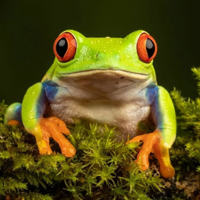

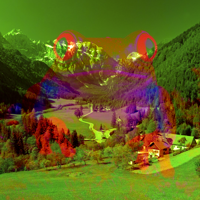

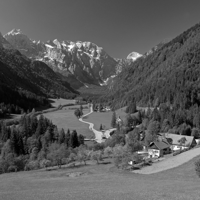

In [696]:
display(source.resize((200, 200)))
display(image.resize((200, 200)))
display(image.convert('L').resize((200, 200)))

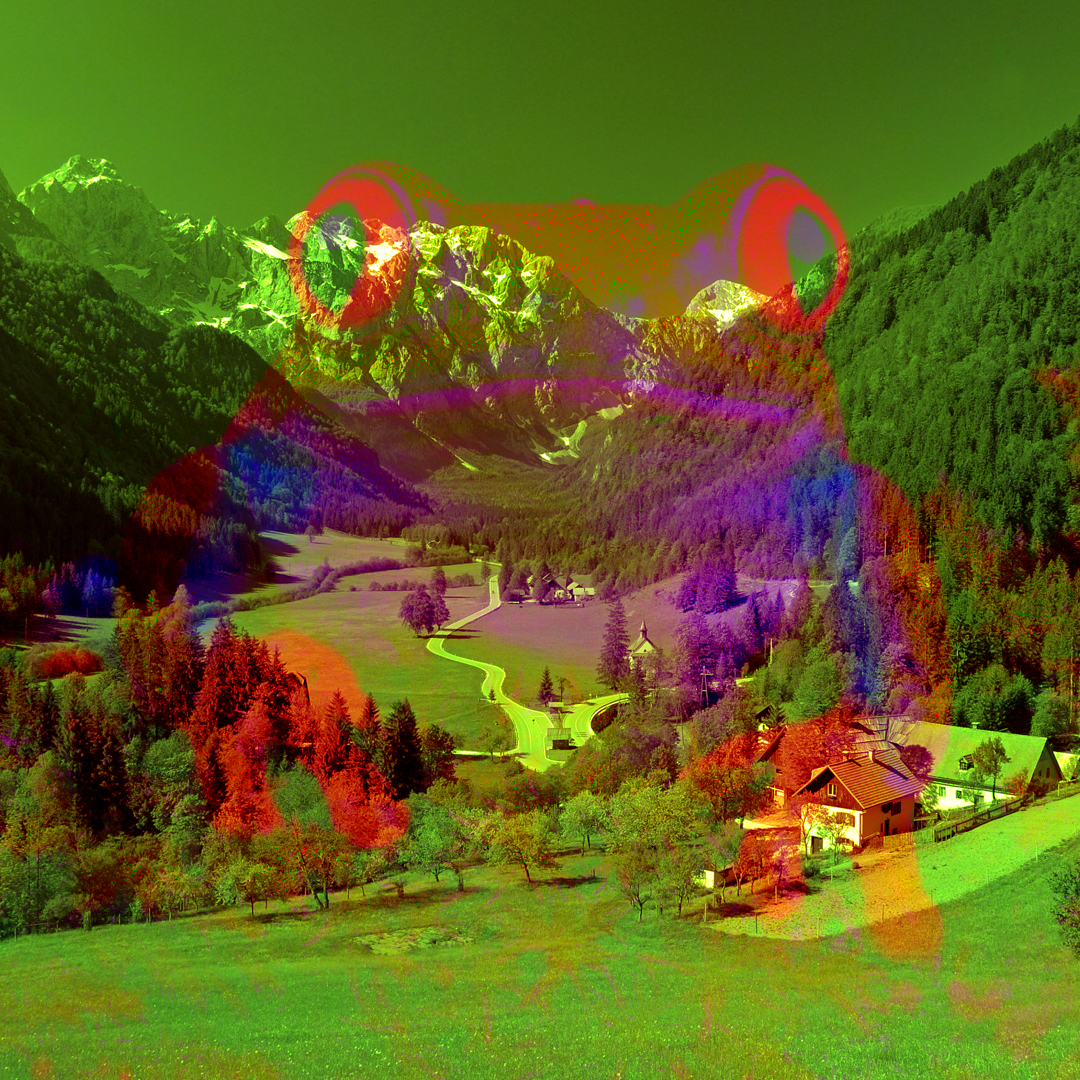

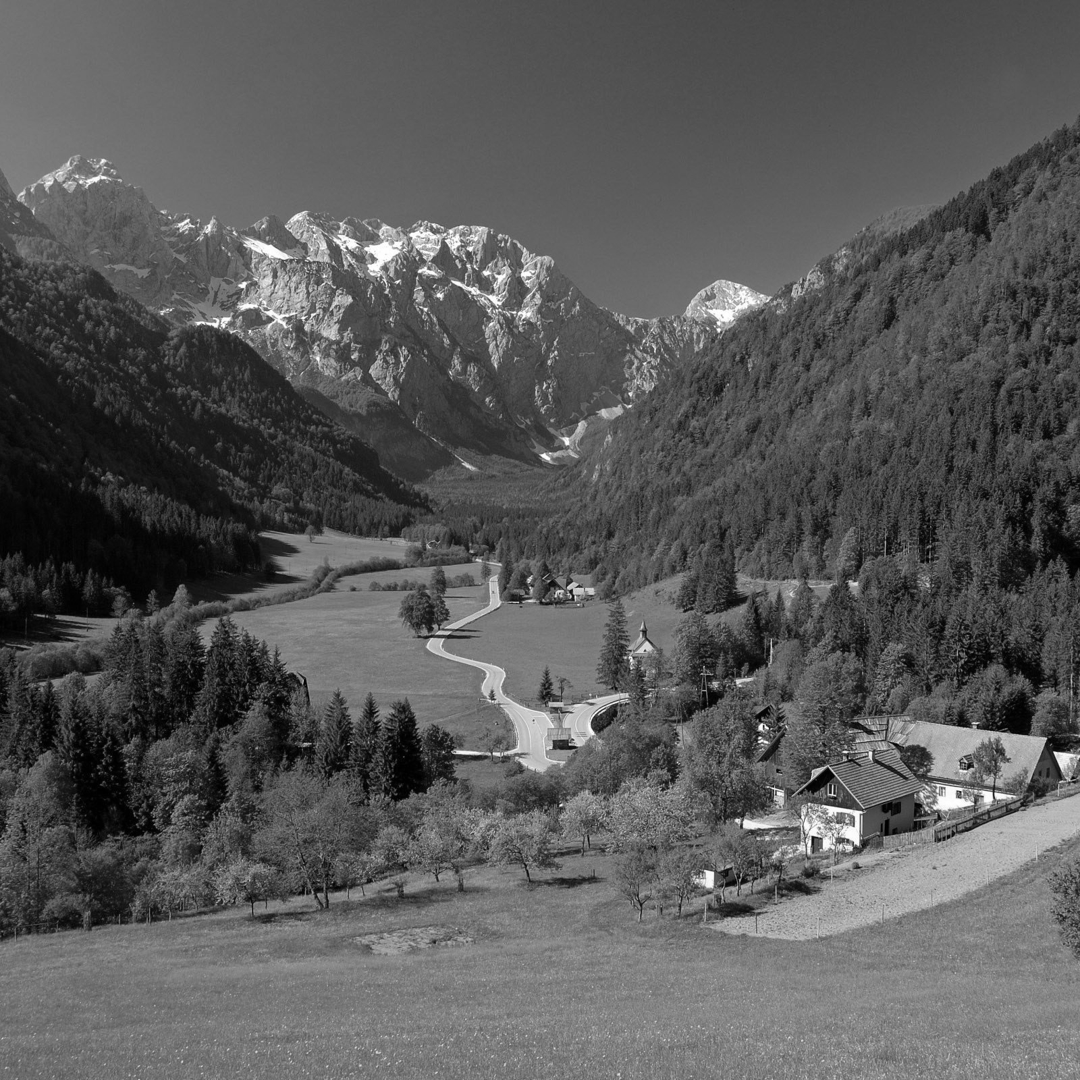

In [698]:
display(image)
display(image.convert('L'))